In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# TIF to Numpy Conversion

In [3]:

def tif_to_npy(tif_file, npy_file):
    """
    Convert a .tif file to a .npy array.

    Parameters:
    - tif_file: str, path to the input .tif file.
    - npy_file: str, path to save the output .npy file.
    """
    # Open the .tif file
    with rasterio.open(tif_file) as src:
        # Read the data (assuming single-band raster)
        data = src.read(1)  # Read the first band
        print(f"Data shape: {data.shape}")
        print(f"Data type: {data.dtype}")

    # Save the data as a .npy file
    np.save(npy_file, data)
    print(f"Saved .npy file to: {npy_file}")

# Example usage
tif_file = "/Users/jeremypalmerio/Repos/MasterThesis/Sub-national_rasterized.tif"
npy_file = "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/sub_countries_rasterized.npy"
tif_to_npy(tif_file, npy_file)

Data shape: (16560, 25560)
Data type: int32
Saved .npy file to: /Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/sub_countries_rasterized.npy


Original data shape: (16560, 25560)
Downsampled data shape: (1656, 2556)


/var/folders/sl/lr3h2xdj455ctqq6vn1834000000gn/T/ipykernel_15092/1283260526.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


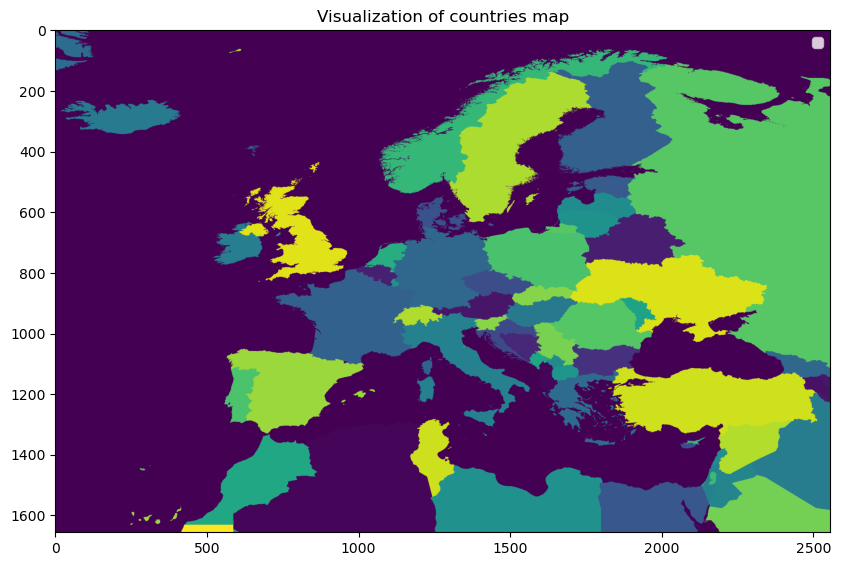

In [4]:

def visualize_npy(npy_file, downsample_factor=10):
    """
    Visualize a large .npy array with optional downsampling.

    Parameters:
    - npy_file: str, path to the .npy file.
    - downsample_factor: int, factor by which to downsample the array.
    """
    # Load the .npy array
    if isinstance(npy_file, str):
        data = np.load(npy_file)
    elif isinstance(npy_file, np.ndarray):
        data = npy_file
    else:
        raise ValueError("Input must be a .npy file or a numpy array.")
    
    print(f"Original data shape: {data.shape}")

    # Downsample the array
    if downsample_factor > 1:
        data = data[::downsample_factor, ::downsample_factor]
        print(f"Downsampled data shape: {data.shape}")

    # Plot the array
    plt.figure(figsize=(10, 8))
    plt.imshow(data)
    # plt.colorbar(label='Value')
    plt.legend()
    plt.title("Visualization of countries map")
    plt.show()

# Example usage
npy_file = "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/countries_rasterized.npy"
# npy_file = "/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_wildfire_Europe.npy"

visualize_npy(npy_file, downsample_factor=10)

# Partition Map Creation

In [5]:
from scipy.ndimage import binary_erosion


In [6]:
countries = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/countries_rasterized.npy")
sub_countries = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/partition_map/sub_countries_rasterized.npy")
wildfires = np.load("/Users/jeremypalmerio/Repos/MasterThesis/Input/Europe/npy_arrays/masked_wildfire_Europe.npy")

wildfires[wildfires > 1] = 1

In [7]:
def create_partition_map(countries: np.ndarray, seed: int = 42) -> np.ndarray:
    """
    Randomly assigns entire countries to train (1), val (2), or test (3) partitions
    with proportions 70%, 15%, 15%. Outputs a partition map with the same shape.
    """
    np.random.seed(seed)
    unique_countries = np.unique(countries)
    unique_countries = unique_countries[unique_countries != 0]  # Exclude the background (0)
    np.random.shuffle(unique_countries)
    
    n = len(unique_countries)
    train_ids = unique_countries[:int(0.7 * n)]
    val_ids = unique_countries[int(0.7 * n):int(0.85 * n)]
    test_ids = unique_countries[int(0.85 * n):]

    partition_map = np.zeros_like(countries, dtype=np.uint8)
    partition_map[np.isin(countries, train_ids)] = 1
    partition_map[np.isin(countries, val_ids)] = 2
    partition_map[np.isin(countries, test_ids)] = 3

    return partition_map

In [8]:
def balance_partition_map(partition_map: np.ndarray, labels: np.ndarray, countries: np.ndarray, seed: int = 42) -> np.ndarray:
    """
    Downsamples negative examples within each country to match the number of positive examples.
    Outputs a new partition map where excess negatives are set to 0 (ignored).
    """
    np.random.seed(seed)
    balanced_map = partition_map.copy()
    
    for split in [1, 2, 3]:
        print(f"Processing split {split}...")
        country_ids = np.unique(countries[partition_map == split])
        for cid in country_ids:
            print(f"Processing country {cid}...")
            mask = (partition_map == split) & (countries == cid)
            pos_inds = np.argwhere(mask & (labels == 1))
            neg_inds = np.argwhere(mask & (labels == 0))
            
            if len(pos_inds) == 0 or len(neg_inds) == 0:
                # If no positives or no negatives, skip this region
                balanced_map[mask & (labels == 0)] = 0
                continue

            # Downsample negatives to match number of positives
            if len(neg_inds) > len(pos_inds):
                selected_neg_inds = neg_inds[np.random.choice(len(neg_inds), size=len(pos_inds), replace=False)]
                all_neg_mask = np.zeros_like(mask, dtype=bool)
                all_neg_mask[tuple(neg_inds.T)] = True
                keep_mask = np.zeros_like(mask, dtype=bool)
                keep_mask[tuple(selected_neg_inds.T)] = True
                discard_mask = all_neg_mask & ~keep_mask
                balanced_map[discard_mask] = 0

    return balanced_map

In [9]:
def clean_partition_map(partition_map: np.ndarray, countries: np.ndarray, countries_to_remove: np.ndarray) -> np.ndarray:
    """
    Removes specified countries from the partition map by setting their cells to 0.
    """
    cleaned_map = partition_map.copy()
    mask = np.isin(countries, countries_to_remove)
    cleaned_map[mask] = 0
    return cleaned_map

In [10]:
def get_partition_stats(partition_map: np.ndarray, labels: np.ndarray, countries: np.ndarray) -> dict:
    """
    Returns a dictionary with detailed statistics for each partition (train=1, val=2, test=3).
    Includes counts of total, positive, and negative samples, class ratio, and country distribution.
    """
    stats = {}
    for split in [1, 2, 3]:
        mask = (partition_map == split)
        total = np.sum(mask)
        positives = np.sum((labels == 1) & mask)
        negatives = np.sum((labels == 0) & mask)
        unique_countries, counts = np.unique(countries[mask], return_counts=True)
        country_distribution = dict(zip(unique_countries.tolist(), counts.tolist()))
        stats[split] = {
            'split_name': {1: 'Train', 2: 'Validation', 3: 'Test'}[split],
            'total_samples': int(total),
            'positives': int(positives),
            'negatives': int(negatives),
            'positive_ratio (%)': round(100 * positives / total, 2) if total > 0 else 0.0,
            'negative_ratio (%)': round(100 * negatives / total, 2) if total > 0 else 0.0,
            'class_balance': f"{positives}:{negatives}",
            'num_countries': len(unique_countries),
            'country_distribution': country_distribution
        }
    return stats

In [11]:
def erode_partition_borders(partition_map: np.ndarray, kernel_size: int = 5) -> np.ndarray:
    """
    Erodes the borders between partition regions to avoid leakage during patch sampling.
    Returns a new map where border-adjacent cells are set to 0.
    
    Args:
        partition_map (np.ndarray): Array with values 1 (train), 2 (val), 3 (test)
        patch_radius (int): Radius of patch to be used (e.g., 2 for 5x5 patches)
    
    Returns:
        np.ndarray: Eroded partition map with border cells removed (set to 0)
    """
    eroded_map = np.zeros_like(partition_map, dtype=np.uint8)+1
    structure = np.ones((kernel_size, kernel_size), dtype=bool)
    ocean_mask = (partition_map == 0)
    for label in [1, 2, 3]:
        print(f"Eroding partition {label}...")
        region_mask = ((partition_map == label) | (partition_map == 0))
        eroded_mask = binary_erosion(region_mask, structure=structure, border_value=4)
        eroded_map[eroded_mask] = label
    eroded_map[ocean_mask] = 0

    return eroded_map

In [12]:
partition_map = create_partition_map(countries, seed=43)

Original data shape: (16560, 25560)
Downsampled data shape: (1656, 2556)


/var/folders/sl/lr3h2xdj455ctqq6vn1834000000gn/T/ipykernel_15092/1283260526.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


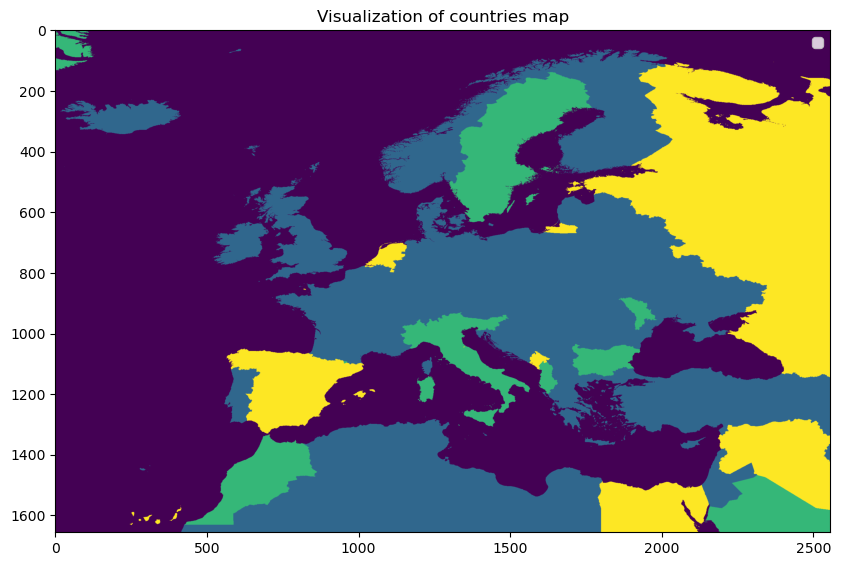

In [13]:
visualize_npy(partition_map, downsample_factor=10)

In [ ]:
eroded_map = erode_partition_borders(partition_map, kernel_size=40)
visualize_npy(eroded_map, downsample_factor=10)

Eroding partition 1...


In [ ]:
get_partition_stats(partition_map, wildfires, countries)

{1: {'split_name': 'Train',
  'total_samples': 118116093,
  'positives': 6508061,
  'negatives': 110441896,
  'positive_ratio (%)': 5.51,
  'negative_ratio (%)': 93.5,
  'class_balance': '6508061:110441896',
  'num_countries': 52,
  'country_distribution': {1: 2857,
   4: 16115958,
   12: 358294,
   15: 1293388,
   16: 163008,
   21: 3625644,
   22: 502981,
   29: 741477,
   57: 857543,
   60: 73625,
   61: 1270209,
   63: 821765,
   75: 34869,
   77: 8185407,
   78: 8374023,
   85: 5962342,
   87: 129,
   88: 1822973,
   94: 1764,
   102: 1428804,
   103: 2538897,
   106: 652103,
   108: 1242089,
   109: 10759,
   110: 271622,
   115: 1091943,
   119: 154131,
   123: 1235087,
   124: 129369,
   127: 9762517,
   128: 2471,
   129: 1195434,
   130: 42554,
   132: 348832,
   138: 4625,
   141: 10195,
   147: 59,
   166: 43883,
   168: 8006781,
   172: 77998,
   180: 5312968,
   181: 1219309,
   186: 3580338,
   201: 1147409,
   206: 780707,
   219: 13471,
   222: 634518,
   233: 1969762,

In [ ]:
np.unique(wildfires, return_counts=True)

(array([ 0.,  1., nan]), array([195650929,  14693006, 212929665]))

Original data shape: (16560, 25560)
Downsampled data shape: (1656, 2556)


/var/folders/sl/lr3h2xdj455ctqq6vn1834000000gn/T/ipykernel_96681/1283260526.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


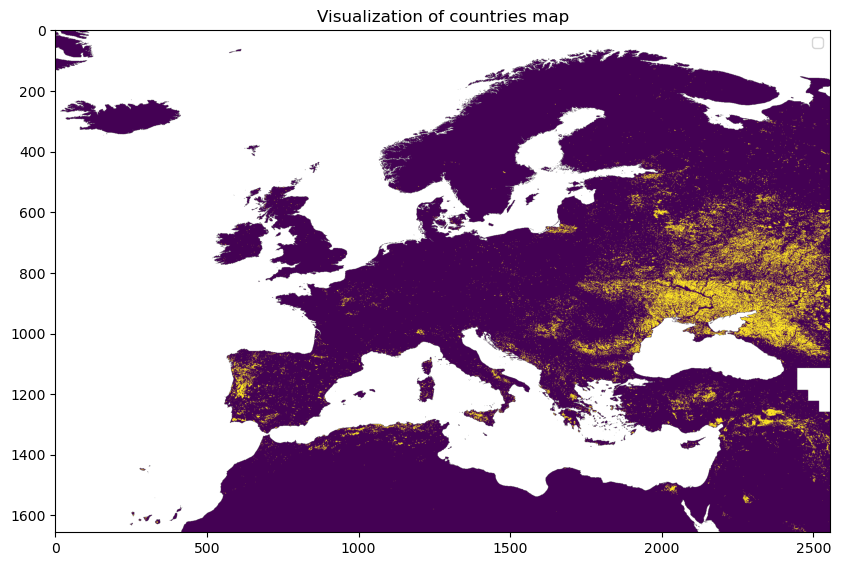

In [ ]:
visualize_npy(wildfires, downsample_factor=10)